# Analyse results from Pypsa-Earth
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Plot capacity - map view: https:\\github.com\pypsa-meets-earth\documentation\blob\main\notebooks\viz\regional_transm_system_viz.ipynb
- Analyse energy potential: https:\github.com\pypsa-meets-earth\documentation\blob\main\notebooks\build_renewable_profiles.ipynb
- Analyse energy generation: https:\pypsa.readthedocs.io\en\latest\examples\statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources\shapes\country_shapes.geojson")
* a renewable profile file (may be found in "resources\renewable_profiles\....nc)

## Import packages

In [1]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

In [2]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("..\..")
sys.path.append(os.getcwd()+"\pypsa-earth\scripts")

## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [7]:
PARENT = os.path.realpath(r'C:\Users\hie\pe_tan\pypsa-earth\\')  + "\\"
config = yaml.safe_load(open(PARENT + "config.yaml"))

# Read config.yaml settings:
name = config["run"]["name"]
simpl = config["scenario"]["simpl"]
clusters = config["scenario"]["clusters"]
ll = config["scenario"]["ll"]
opts = config["scenario"]["opts"]

# Ensure elements are strings and properly joined
simpl_str = "_".join(map(str, simpl))
clusters_str = "_".join(map(str, clusters))
ll_str = "_".join(map(str, ll))
opts_str = "_".join(map(str, opts))

nc_file_name = f"elec_s{simpl_str}_{clusters_str}_ec_l{ll_str}_{opts_str}.nc"
scenario_name = name 
scenario_subpath = ""

# Network file
results_path = PARENT + f"results\{scenario_subpath}networks\{nc_file_name}"
network_path = PARENT + f"networks\{scenario_subpath}elec.nc"
# Country shape file
regions_onshore_path = PARENT + f"resources\{scenario_subpath}shapes\country_shapes.geojson"
# Renewable profile file
solar_path = PARENT + f"resources\{scenario_subpath}renewable_profiles\profile_solar.nc"
onwind_path = PARENT + f"resources\{scenario_subpath}renewable_profiles\profile_onwind.nc"

## Energy system analysis setup - power and energy generation

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)
n = pypsa.Network(results_path)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hie\\pe_tan\\pypsa-earth\\results\\networks\\elec_s_25_ec_lcopt_24h.nc'

## Data import check

Plot of the region of interest

Text(0.5, 1.0, 'TZ')

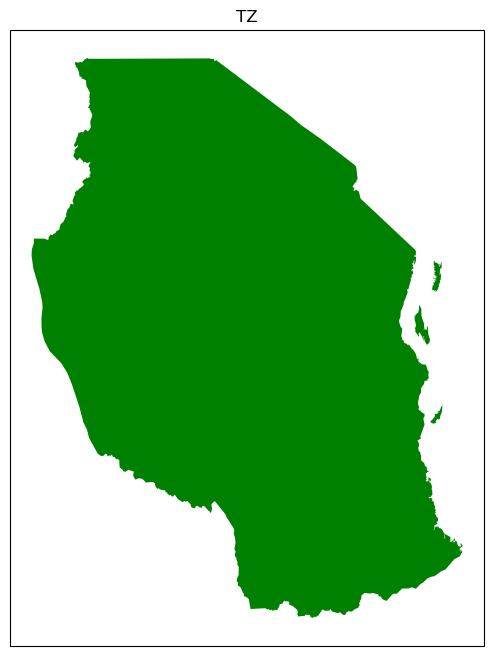

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

List number of components by type

In [ ]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 78 entries
Component 'Carrier' has 15 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 35 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 78 entries
Component 'Load' has 39 entries
Component 'Generator' has 165 entries
Component 'StorageUnit' has 4 entries
Component 'Store' has 39 entries


List the snapshots of the PyPSA network

In [ ]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='snapshot', length=365, freq=None)
Time steps: 365


## Analyse energy system

Analyse the current capacity of the energy system - map view

In [6]:
# Scale settings
bus_scale = 6e3 
line_scale = 6e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

NameError: name 'n' is not defined

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier')

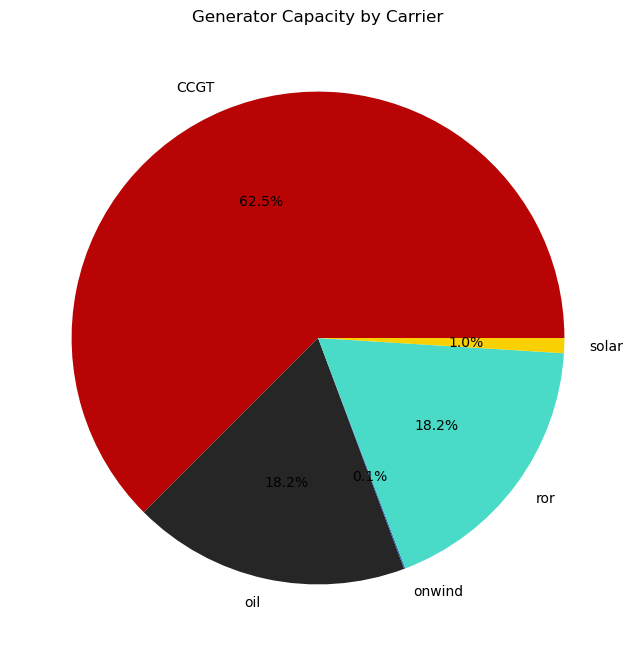

In [ ]:
generator_capacity_by_carrier = (
    n.generators[n.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)
plt.figure(figsize=(8, 8))
plt.pie(
    generator_capacity_by_carrier,
    labels=generator_capacity_by_carrier.index,
    autopct='%1.1f%%',
    colors=n.carriers[
            n.carriers.index.isin(generator_capacity_by_carrier.index)
        ].color.reindex(generator_capacity_by_carrier.index)
)
plt.title("Generator Capacity by Carrier")

Analyse the current gernation capacity of the energy system - tabular view

In [ ]:
generator_capacity_by_carrier\1e3 # in GW

SyntaxError: unexpected character after line continuation character (3585896987.py, line 1)

Analyse the future capacity of the energy system - map view

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses \ bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt \ line_scale,
        link_widths=n.links.p_nom_opt \ line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s \ bus_scale for s in bus_sizes],
    [f"{s \ 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s \ line_scale for s in line_sizes],
    [f"{s \ 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

SyntaxError: unexpected character after line continuation character (1410163816.py, line 8)

Analys the future generation capacity expansion of the energy system - bar chart

<AxesSubplot:title={'center':'Generator capacity expansion in GW'}, xlabel='carrier'>

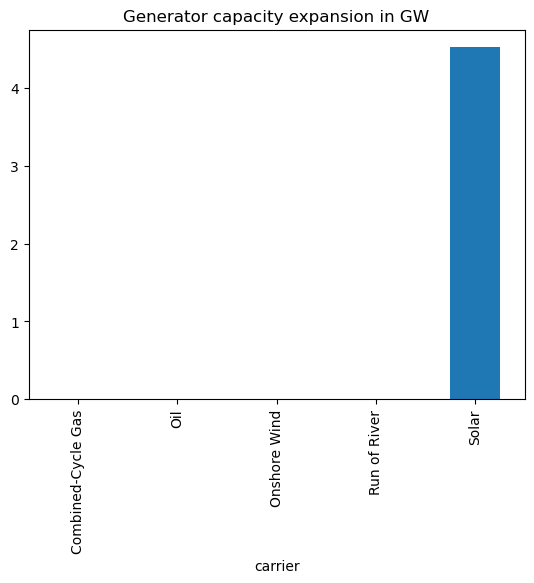

In [ ]:
optimal_capacity = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [ ]:
generation_capacity_expansion # In GW

carrier
Combined-Cycle Gas    0.000000e+00
Oil                   0.000000e+00
Onshore Wind          2.056093e-07
Run of River          0.000000e+00
Solar                 4.519815e+00
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

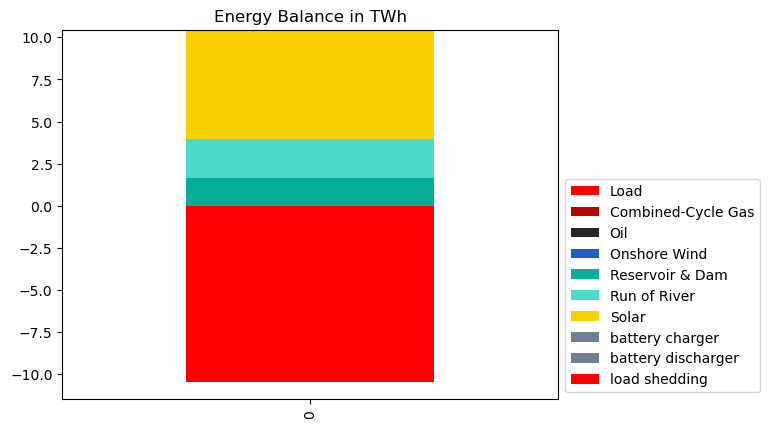

In [ ]:
colors = {key.lower(): value.lower() for key, value in config["plotting"]["tech_colors"].items()}
nice_names = {value.lower(): key for key, value in config["plotting"]["nice_names"].items()}

rename_cols = {
    '-': 'Load',
    'load': 'load shedding',
}

energy_balance = (
    n.statistics.energy_balance()
    .loc[:, :, "AC"]
    .groupby("carrier")
    .sum()
    .div(1e6)
    .to_frame()
    .T
    .rename(columns=rename_cols)
)

# color-matching
color_list = []
for col in energy_balance.columns:
    original_name = col.lower()
    key_name = nice_names.get(original_name, original_name)
    color = colors.get(key_name.lower(), 'gray')
    color_list.append(color)


fig, ax = plt.subplots()
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=color_list)
handles, labels = ax.get_legend_handles_labels()
nice_labels = [config["plotting"]["nice_names"].get(label, label) for label in energy_balance.columns]
ax.legend(handles, nice_labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

plt.show()

Analyse the future energy generation of the energy system - tabular view

In [ ]:
n.statistics.energy_balance()/1e6 # In TWh

component    carrier             bus_carrier
Link         battery charger     AC            -8.940117e-03
             battery discharger  battery       -8.582512e-03
             battery charger     battery        8.582512e-03
             battery discharger  AC             8.239212e-03
Load         -                   AC            -1.044053e+01
Store        Battery Storage     battery       -7.918665e-20
StorageUnit  Reservoir & Dam     AC             1.637435e+00
Generator    Combined-Cycle Gas  AC             9.940791e-03
             Oil                 AC             2.515737e-09
             Onshore Wind        AC             1.008926e-03
             Run of River        AC             2.340023e+00
             Solar               AC             6.452820e+00
             load                AC             9.722218e-11
                                 battery        9.596760e-11
dtype: float64

## Analyse pv and wind potential - map view

In [ ]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"{PARENT}resources\{scenario_name}\bus_regions\regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot wind energy potential

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW\km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


DataSourceError: 'C:\Users\hie\pe_tan\pypsa-earth\resources\us_regionsegions_onshore.geojson' does not exist in the file system, and is not recognized as a supported dataset name.

Plot pv energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


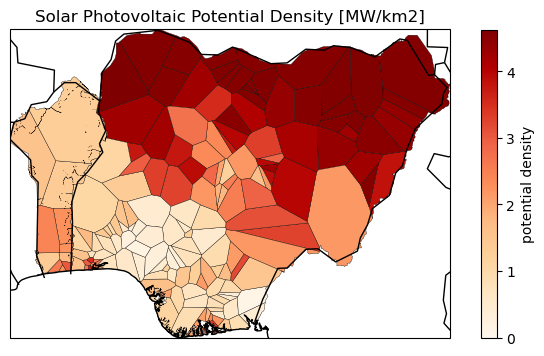

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW\km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)